In [5]:
# coding: utf-8
__author__ = 'ZFTurbo: https://kaggle.com/zfturbo'

import cv2
import numpy as np
import pandas as pd
import random
import pickle
from PIL import Image
from os.path import isfile
from IPython.display import Image, display
import matplotlib.pyplot as plt
%matplotlib inline

%load_ext autoreload
%autoreload 2

In [2]:
BOX_SIZE = 512

def preprocess_image(img):
    from keras.applications.densenet import preprocess_input
    return preprocess_input(img)

def get_branch_model(inp_shape):
    from keras.applications.densenet import DenseNet121
    model = DenseNet121(input_shape=inp_shape, include_top=False, weights=None, pooling='max')
    return model


def build_model(img_shape, activation='sigmoid'):
    from keras import backend as K
    from keras.optimizers import Adam
    from keras.engine.topology import Input
    from keras.layers import Concatenate, Conv2D, Dense, Flatten, Lambda, Reshape
    from keras.models import Model, load_model

    optim = Adam(lr=0.0001)
    branch_model = get_branch_model(img_shape)

    mid = 32
    xa_inp = Input(shape=branch_model.output_shape[1:], name='hm_inp_a')
    xb_inp = Input(shape=branch_model.output_shape[1:], name='hm_inp_b')
    x1 = Lambda(lambda x: x[0] * x[1], name='lambda_1')([xa_inp, xb_inp])
    x2 = Lambda(lambda x: x[0] + x[1], name='lambda_2')([xa_inp, xb_inp])
    x3 = Lambda(lambda x: K.abs(x[0] - x[1]), name='lambda_3')([xa_inp, xb_inp])
    x4 = Lambda(lambda x: K.square(x), name='lambda_4')(x3)
    x = Concatenate(name='concat_1')([x1, x2, x3, x4])
    x = Reshape((4, branch_model.output_shape[1], 1), name='reshape1')(x)

    # Per feature NN with shared weight is implemented using CONV2D with appropriate stride.
    x = Conv2D(mid, (4, 1), activation='relu', padding='valid', name='hm_conv_2d_1')(x)
    x = Reshape((branch_model.output_shape[1], mid, 1), name='hm_reshape_2')(x)
    x = Conv2D(1, (1, mid), activation='linear', padding='valid', name='hm_conv_2d_2')(x)
    x = Flatten(name='flatten')(x)

    # Weighted sum implemented as a Dense layer.
    x = Dense(1, use_bias=True, activation=activation, name='weighted-average')(x)
    head_model = Model([xa_inp, xb_inp], x, name='head')

    ########################
    # SIAMESE NEURAL NETWORK
    ########################
    # Complete model is constructed by calling the branch model on each input image,
    # and then the head model on the resulting 512-vectors.
    img_a = Input(shape=img_shape)
    img_b = Input(shape=img_shape)
    xa = branch_model(img_a)
    xb = branch_model(img_b)
    x = head_model([xa, xb])
    model = Model([img_a, img_b], x, name='full_model')
    model.compile(optim, loss='binary_crossentropy', metrics=['binary_crossentropy', 'acc'])
    return model, branch_model, head_model


def get_trained_model():
    model, branch_model, head_model = build_model(img_shape=(BOX_SIZE, BOX_SIZE, 3))
    model.load_weights('../input/whales-2019-models/ft_v5_512px_finetune_0_final_v2_0.969993.model')
    return model, branch_model, head_model

In [3]:
def expand_path(p):
    if isfile('../input/humpback-whale-identification/train/' + p):
        return '../input/humpback-whale-identification/train/' + p
    if isfile('../input/humpback-whale-identification/test/' + p):
        return '../input/humpback-whale-identification/test/' + p
    return p


def get_boxes():
    temp_p2bb = pickle.load(open('../input/whales-2019-models/p2bb_averaged_v1.pkl', 'rb'))
    p2bb = {}
    for k in temp_p2bb:
        p2bb[k + '.jpg'] = temp_p2bb[k]
    return p2bb


def read_single_image(path):
    try:
        img = np.array(Image.open(path))
    except:
        try:
            img = cv2.cvtColor(cv2.imread(path), cv2.COLOR_BGR2RGB)
        except:
            print('Fail')
            return None

    if len(img.shape) == 2:
        img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)

    if img.shape[2] == 2:
        img = img[:, :, :1]

    if img.shape[2] == 1:
        img = np.concatenate((img, img, img), axis=2)

    if img.shape[2] > 3:
        img = img[:, :, :3]

    return img


def read_cropped_image(p, x0, y0, x1, y1, img_shape=(224, 224, 3)):
    anisotropy = 2.15
    crop_margin = 0.05

    # Read the image
    img = read_single_image(p)
    size_x, size_y = img.shape[1], img.shape[0]

    dx = x1 - x0
    dy = y1 - y0
    x0 -= dx * crop_margin
    x1 += dx * crop_margin + 1
    y0 -= dy * crop_margin
    y1 += dy * crop_margin + 1
    if x0 < 0: x0 = 0
    if x1 > size_x: x1 = size_x
    if y0 < 0: y0 = 0
    if y1 > size_y: y1 = size_y
    dx = x1 - x0
    dy = y1 - y0
    if dx > dy * anisotropy:
        dy = 0.5 * (dx / anisotropy - dy)
        y0 -= dy
        y1 += dy
    else:
        dx = 0.5 * (dy * anisotropy - dx)
        x0 -= dx
        x1 += dx

    if x0 < 0: x0 = 0
    if x1 > size_x: x1 = size_x
    if y0 < 0: y0 = 0
    if y1 > size_y: y1 = size_y
    x0, y0, x1, y1 = int(x0), int(y0), int(x1), int(y1)

    if y0 != y1 and x0 != x1:
        img = img[y0:y1, x0:x1, :]
    img = cv2.resize(img, (img_shape[1], img_shape[0]), interpolation=cv2.INTER_LINEAR)
    if len(img.shape) == 2:
        img = np.concatenate((img, img, img), axis=2)

    return img

In [4]:
model, branch_model, head_model = build_model(img_shape=(BOX_SIZE, BOX_SIZE, 3))

Using TensorFlow backend.


(270, 224, 224, 3)


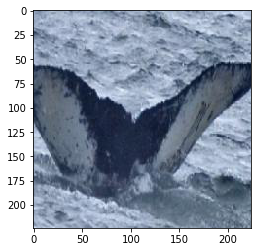